<a href="https://colab.research.google.com/github/kushsharma2910/FGQ/blob/kush/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import time
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, BatchNormalization, TimeDistributed, RepeatVector, Reshape, Lambda
from keras.layers import LSTM, LeakyReLU, RepeatVector, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers, initializers
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
import keras.backend.tensorflow_backend as tfb

Using TensorFlow backend.


In [0]:
#######################################################################################
################################# CREATING LARGEDF  ###################################
#######################################################################################

def change_index_to_time(df):
    if "Time (UTC)" in df.columns:
      df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'])
      df.set_index('Time (UTC)', inplace = True, drop = True)
    
#Finds the dataframe with largest number of time stamps and returns an empty dataframe with same index
def create_empty_df(dir_name):
    largest_timeframe = 0
    path_to_largest = ""

    for asset_class in os.listdir(dir_name):
        for asset in os.listdir(dir_name +  "/" + asset_class):    
            df = pd.read_csv(dir_name +  "/" + asset_class + "/" + asset)
            if df.shape[0] > largest_timeframe:
                largest_timeframe = df.shape[0]
                path_to_largest = dir_name +  "/" + asset_class + "/" + asset

    largest_dataframe = pd.read_csv(path_to_largest)
    change_index_to_time(largest_dataframe)
    largest_dataframe = pd.DataFrame(index = largest_dataframe.index)
    return largest_dataframe

#######################################################################################
################################# FEATURE BUILDING  ###################################
#######################################################################################

def fill_large_df(dir_name, large_df):
    asset67 = []
    for asset_class in os.listdir(dir_name):
        for asset in os.listdir(dir_name +  "/" + asset_class): 
            extract_name = asset.split("_")
            asset67.append(extract_name[0][:-4])
            df = pd.read_csv(dir_name +  "/" + asset_class + "/" + asset)
            change_index_to_time(df)
            large_df = large_df.join(df)
            rename_dic = {}
            for column in df.columns:    
                rename_dic[column] = column + "@" + extract_name[0][:-4]
            large_df = large_df.rename(columns = rename_dic) 
            
    return large_df, asset67

def add_lag_features(only_feat_df):
  lag_feat = only_feat_df.copy()
  BASE_FEATURES = ["Open@" + target_asset, "High@" + target_asset, "Low@" + target_asset, "Close@" + target_asset]
  N_WINDOW = [4, 24, 128, 256]
  prevlag = 1 
  for window in N_WINDOW:
    rolled = lag_feat[BASE_FEATURES].shift(prevlag).rolling(window=window)
    lag_feat = lag_feat.join(rolled.mean().add_suffix(f'_window_{window}_mean'))
    lag_feat = lag_feat.join(rolled.max().add_suffix(f'_window_{window}_max'))
    lag_feat = lag_feat.join(rolled.min().add_suffix(f'_window_{window}_min'))
    lag_feat = lag_feat.join(rolled.std().add_suffix(f'_window_{window}_std'))
  return lag_feat

def remove_spread(df, target_asset):
    target_asset_spread = []
    features = ["Open", "High", "Low", "Close", "Volume "]

    for feature in features:
        target_asset_spread.append(feature + "_spread@" + target_asset)

    remove_columns = []
    for column in df.columns:
        if (column not in target_asset_spread) and ("spread" in column):
            remove_columns.append(column)

    df = df.drop(columns = remove_columns)
    return df

def denoise_fft(df, target_asset, level):
    features = ["Open@" + target_asset, "High@" + target_asset, "Low@" + target_asset, "Close@" + target_asset]
    
    for feature in features:
        close_fft = np.fft.fft(np.asarray(df[feature].tolist()))
        fft_df = pd.DataFrame({'fft':close_fft})
        fft_list = np.asarray(fft_df['fft'].tolist())
        fft_list_m10 = np.copy(fft_list)
        fft_list_m10[level:-level] = 0
        df[feature] = np.real(np.fft.ifft(fft_list_m10))

def extract_features(large_df, target_asset, target_window, asset67, \
                    add_lag = False, keep_spread = True, denoise = True):
    df = large_df.copy()

    if denoise == True:
        level = 2000
        denoise_fft(df, target_asset, level)

    #remove the spread columns of assets
    #other than the target asset
    if keep_spread == False:
        df = remove_spread(df, target_asset)

    #comment out this line if you 
    #don't want to use the lag features
    if add_lag == True:
      df = add_lag_features(df)

    df["H-" + str(target_window) + "hr" ] = df.pop("H-" + str(target_window) + "hr@" + target_asset)
    df["L-" + str(target_window) + "hr" ] = df.pop("L-" + str(target_window) + "hr@" + target_asset)
    
    #removing targets of assets other
    # than the target assset
    for asset in asset67:
        if asset != target_asset:
            df = df.drop(columns = ["H-4hr@" + asset, "L-4hr@" + asset, "H-12hr@" + asset,
                               "L-12hr@" + asset, "H-24hr@" + asset,"L-24hr@" + asset])
            
    #this loop asserts that labels for target asset is
    #not present for other windows
    windows = ["4", "12", "24"]
    for window in windows:
      if window != str(target_window):
        high = "H-" + window + "hr@" + target_asset
        low = "L-" + window + "hr@" + target_asset
        if high in df.columns:
          df = df.drop(columns = [high])
        if low in df.columns:
          df = df.drop(columns = [low])

    change_index_to_time(df)        
    return df

def normalize_df(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def standard_df(df):
    result = df.copy()
    for feature_name in df.columns:
        df[feature_name] = (df[feature_name]-df[feature_name].mean()) / df[feature_name].std()
    return result

#######################################################################################
################################# MODEL BUILDING  #####################################
#######################################################################################


#predicting the H as previous value
def create_baseline(only_feat_df, direction, target_window):     
    preds = np.array(pd.Series(only_feat_df[direction + "-" + str(target_window) + "hr"]).shift(1).bfill(axis = 0))
    actual = np.array(only_feat_df[direction + "-" + str(target_window) + "hr"])
    return preds, actual

#######################################################################################
############################# ACCURACY CALCULATIONS  ##################################
#######################################################################################

def acc_abs(preds, actual, tolerance):
    tolerance /= 100
    return np.sum(np.abs(preds/actual-1) <= tolerance) / preds.shape[0]

def acc_dir(preds, actual, tolerance, direction):
    tolerance /= 100
    score = 0
    for ix in range(preds.shape[0]):
        if actual[ix] > preds[ix]*(1+tolerance)  and direction == "H":
            score += 1
        elif actual[ix] < preds[ix]*(1-tolerance)  and direction == "L":
             score += 1
    return score / preds.shape[0]

def min_pips(preds, actual, opens, tolerance, pips, direction):
    pips /= 100
    tolerance /= 100
    score = 0
    for ix in range(preds.shape[0]):
        if preds[ix] < actual[ix]*(1+tolerance)  and (direction == "H" and (actual[ix] - opens[ix])>=pips):
            score += 1 
        elif preds[ix] > actual[ix]*(1+tolerance)  and (direction == "L" and (opens[ix] - actual[ix])>=pips):
             score += 1
    return score / preds.shape[0]

In [0]:
#name of the root directory which contains asset classes which further contain asset csv ask and bid pairs
# dir_name = "drive/My Drive/FGQ/Assets"
# large_df = create_empty_df(dir_name)

In [0]:
#asset67 contains the 67 selected assets which have data for more than 6 years
# large_df_, asset67 = fill_large_df(dir_name, large_df)

In [0]:
#Filling in previous values for values in middle
# large_df_ = large_df_.ffill(axis=0)

#Filling in next value for initial nan values
#This is used for assets which do not have initial data
# large_df_ = large_df_.bfill(axis=0)

In [8]:
#When using google drive

#to extract to the home dir
!unzip "drive/My Drive/FGQ/large_df_.zip"
large_df_ = pd.read_csv("large_df_.csv")

#List of assets present in large_df_
asset67 = np.array(pd.read_csv("drive/My Drive/FGQ/asset67.csv").iloc[:, 1])

Archive:  drive/My Drive/FGQ/large_df_.zip
  inflating: large_df_.csv           


In [0]:
#input variables
target_asset = "XAGUSD"
target_window = 12
direction = "L"
#give tolerance in percent
tolerance = 0.5
#in the xlsx file, first row and columns have been removed for efficient reading
pip_xl = pd.read_excel("drive/My Drive/FGQ/Labels to Forecast.xlsx")

#querying pips
pips = pip_xl[pip_xl["Label"] == target_asset][str(target_window) + " Hour"].values[0]

only_feat_df = extract_features(large_df_, target_asset, target_window, asset67, add_lag=False, keep_spread=False, denoise=True)

In [0]:
# preds, actual = create_baseline(only_feat_df, direction, target_window)

# #calculate accuracies
# print(acc_abs(preds, actual, tolerance))
# print(acc_dir(preds, actual, tolerance, direction))
# print(min_pips(preds, actual, only_feat_df["Open@" + target_asset], tolerance, pips, direction))

In [11]:
features = ["Open@" + target_asset, "High@" + target_asset, "Low@" + target_asset, "Close@" + target_asset, direction + "-" + str(target_window) + "hr"]

# features = []
# for feature in only_feat_df.columns:
#     if target_asset in feature:
#         features.append(feature)
# features.append(direction + "-" + str(target_window) + "hr")

only_norm = normalize_df(only_feat_df[features])
# only_norm = standard_df(only_feat_df[features])

#using only half training data for faster training
split = int(0.5 * only_norm.shape[0])
only_norm = only_norm.iloc[:split, :]

print(only_norm.shape)

(62363, 5)


In [0]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)

params = {
    "batch_size": 512, 
    "epochs": 150,
    "lr_g": 0.00070000,
    "lr_d": 0.00700000,
    "time_steps": 256,
    #"n_outputs" : 2*target_window
    "n_outputs" : 8
}

OUTPUT_PATH = "drive/My Drive/FGQ/models/"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
N_OUTPUTS = params["n_outputs"]

def trim_dataset(x_t,batch_size):
    no_of_rows_drop = x_t.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return x_t[:-no_of_rows_drop]
    else:
        return x_t

def build_timeseries(only_norm):
    temp_dir = direction
    if temp_dir == "H":
        temp_dir = "High@"
    else:
        temp_dir = "Low@"
    Y = only_norm[temp_dir + target_asset]
    dim_0 = only_norm.shape[0] - N_OUTPUTS - TIME_STEPS
    dim_1 = only_norm.shape[1]-1
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0, N_OUTPUTS))
    target_prices = np.zeros((dim_0, ))
    for i in tqdm_notebook(range(dim_0)):
        x[i] = only_norm.iloc[i:TIME_STEPS+i, :-1]
        y[i] = Y[TIME_STEPS+i : TIME_STEPS+i+N_OUTPUTS]
        target_prices[i] = only_norm[direction + "-" + str(target_window) + "hr"].iloc[i+TIME_STEPS]
    return x, y, target_prices

In [0]:
feat_to_ind = {
    'O' : 0,
    'H' : 1,
    'L' : 2,
    'C' : 3
}

In [0]:
def create_generator():
    generator = Sequential()
    generator.add(LSTM(50, input_shape=(TIME_STEPS, x_t.shape[2]), dropout=0.2, recurrent_dropout=0.2, stateful=False, kernel_initializer='zeros'))
    generator.add(RepeatVector(N_OUTPUTS))
    generator.add(LSTM(25, return_sequences=True))
    # generator.add(TimeDistributed(Dense(16, activation='relu')))
    generator.add(TimeDistributed(Dense(1)))
    optimizer = optimizers.Adam(lr=params["lr_g"])
    generator.compile(loss='mse', optimizer=optimizer)
    return generator

def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv1D(8, kernel_size=3, strides=2, padding = 'same', input_shape=(N_OUTPUTS + TIME_STEPS, 1), 
                            kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(alpha = 0.01))
    discriminator.add(Conv1D(16, kernel_size=3, strides=2, padding = 'same'))
    discriminator.add(LeakyReLU(alpha = 0.01))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))
    discriminator.add(MaxPooling1D(pool_size=2))
    discriminator.add(Flatten())
    discriminator.add(Dense(50, activation='relu'))
    discriminator.add(Dense(1, activation='sigmoid'))
    optimizer = optimizers.Adam(lr=params["lr_d"])
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def modify(tensors):
    return concatenate([tf.slice(tensors[0], [0, 0, feat_to_ind[direction]], [-1, -1, 1]), tensors[1]], axis = 1)

def binary_crossentropy_custom(y_true, y_pred):
    return K.mean(binary_crossentropy_custom_tf(y_true, y_pred), axis=-1)

def binary_crossentropy_custom_tf(target, output, from_logits=False):
    """Binary crossentropy between an output tensor and a target tensor.

    # Arguments
        target: A tensor with the same shape as `output`.
        output: A tensor.
        from_logits: Whether `output` is expected to be a logits tensor.
            By default, we consider that `output`
            encodes a probability distribution.

    # Returns
        A tensor.
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    if not from_logits:
        # transform back to logits
        _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
        output = tf.log(output / (1 - output))

    return tf.nn.sigmoid_cross_entropy_with_logits(labels=target,
                                                   logits=output)

# def custom_loss():
#     _EPSILON = K.epsilon()
#     def loss(y_true,y_pred):
#         y_pred = K.constant(y_pred) if not K.is_tensor(y_pred) else y_pred
#         y_true = K.cast(y_true, y_pred.dtype)
#         return K.mean(
#             K.binary_crossentropy(y_true, y_pred, axis=-1)

#     return loss

def create_gan(generator, discriminator):
    discriminator.trainable = False
    ganInput = Input(shape=(TIME_STEPS, x_t.shape[2]))
    x = generator(ganInput)
    mod_x = Lambda(modify)([ganInput, x])
    ganOutput = discriminator(mod_x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    optimizer = optimizers.Adam(lr=params["lr_g"])
    gan.compile(loss = binary_crossentropy_custom, optimizer=optimizer, metrics =['binary_accuracy'])
    return gan

In [15]:
df_train, df_test = train_test_split(only_norm, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

x_t, y_t, target_prices_t = build_timeseries(df_train)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
target_prices_t = trim_dataset(target_prices_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

x_temp, y_temp, target_prices_temp = build_timeseries(df_test)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
target_prices_val, target_prices_test_t = np.split(trim_dataset(target_prices_temp, BATCH_SIZE),2)

x_val = trim_dataset(x_val, BATCH_SIZE)
y_val = trim_dataset(y_val, BATCH_SIZE)
target_prices_val = trim_dataset(target_prices_val, BATCH_SIZE)

x_test_t = trim_dataset(x_test_t, BATCH_SIZE)
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
target_prices_test_t = trim_dataset(target_prices_t, BATCH_SIZE)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

Train--Test size 49890 12473



Batch trimmed size (49152, 256, 4) (49152, 8)



Test size (5632, 256, 4) (5632, 8) (5632, 256, 4) (5632, 8)


In [0]:
discriminator = create_discriminator()
generator = create_generator()
gan = create_gan(generator, discriminator)

In [0]:
def validation_plot():
    BATCH_COUNT_VAL = int(x_val.shape[0] / BATCH_SIZE)
    x_val_list = np.split(x_val, BATCH_COUNT_VAL)
    pred_prices = np.zeros((target_prices_val.shape[0], ))
    for b_num in range(BATCH_COUNT_VAL):
        pred_seq = generator.predict(x_val_list[b_num], batch_size=BATCH_SIZE)
        if direction == "L":
            pred_prices[b_num*BATCH_SIZE : (b_num+1)*BATCH_SIZE] = np.min(pred_seq, axis = 1)[:, 0]
        else:
            pred_prices[b_num*BATCH_SIZE : (b_num+1)*BATCH_SIZE] = np.max(pred_seq, axis = 1)[:, 0]


    print("mse : ")
    print(mean_squared_error(target_prices_val, pred_prices))

    plt.figure(figsize = (18, 5))
    plt.plot(pred_prices, label = 'pred_prices')
    # plt.show()

    # plt.figure(figsize = (18, 5))
    plt.plot(target_prices_val, label = 'target_prices')
    plt.legend()
    plt.show()

In [0]:
dLosses = []
gLosses = []

In [0]:
def plot_loss():
    plt.figure(figsize=(18, 5))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.legend()
    plt.show()

In [0]:
def train_():
    EPOCHS = params["epochs"]
    BATCH_SIZE = params["batch_size"]
    BATCH_COUNT = int(x_t.shape[0] / BATCH_SIZE)
    for e in (range(1, EPOCHS+1)):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        x_t_list = np.split(x_t, BATCH_COUNT)
        y_t_list = np.split(y_t, BATCH_COUNT)

        for b_num in tqdm_notebook(range(BATCH_COUNT)):

            fake_seq = generator.predict(x_t_list[b_num], batch_size = BATCH_SIZE) 
            fake_seq = np.concatenate((x_t_list[b_num][:, :, feat_to_ind['L']], fake_seq[:, :, 0]), axis = 1)
            fake_seq = fake_seq.reshape(BATCH_SIZE, N_OUTPUTS + TIME_STEPS, 1)

            real_seq = y_t_list[b_num]
            real_seq = np.concatenate((x_t_list[b_num][:, :, feat_to_ind['L']], real_seq), axis = 1)
            real_seq = real_seq.reshape(BATCH_SIZE, N_OUTPUTS + TIME_STEPS, 1)

            x_stack = np.concatenate([fake_seq, real_seq])
            
            y_stack = np.zeros(2*BATCH_SIZE)
            y_stack[BATCH_SIZE:] = 0.9
            y_stack = y_stack.reshape(-1, 1)
            
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(x_stack, y_stack)
            
            discriminator.trainable = False
            gloss = gan.train_on_batch(x_t_list[b_num], np.ones(BATCH_SIZE))

        dLosses.append(dloss)
        gLosses.append(gloss)

            #This line of code checks that generator works well as a standalone
            # generator.train_on_batch(x_t_list[b_num], y_t_list[b_num].reshape(BATCH_SIZE, N_OUTPUTS, 1))

        if e == 1 or e % 1 == 0:
            validation_plot()   
            #plot_loss()

--------------- Epoch 1 ---------------



mse : 
0.0012742885963622004


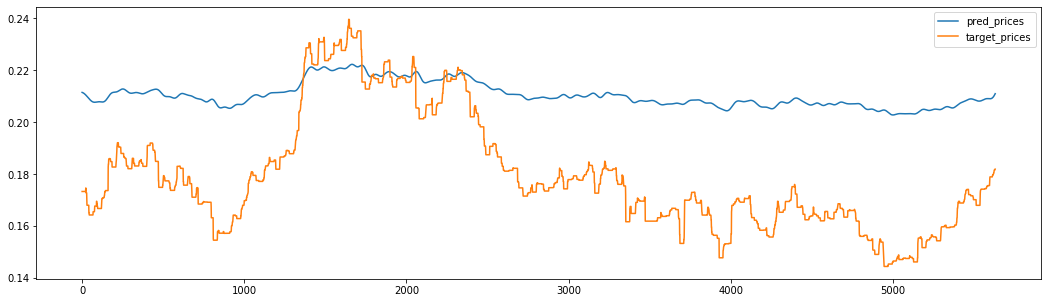

--------------- Epoch 2 ---------------


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-e8af12e8afbe>", line 1, in <module>
    train_()
  File "<ipython-input-20-4d7d0375f069>", line 30, in train_
    gloss = gan.train_on_batch(x_t_list[b_num], np.ones(BATCH_SIZE))
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1449, in train_on_batch
    outputs = self.train_function(ins)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2979, in __call__
    return self._call(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2937, in _call
    fetched = self._callable_fn(*array_vals)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py", line 1472, in __call__
    run_metadata_ptr)
KeyboardInterrupt

During handling o

KeyboardInterrupt: ignored

In [21]:
train_()

In [0]:
 def test_plot():
    BATCH_COUNT_TES = int(x_test_t.shape[0] / BATCH_SIZE)
    x_test_list = np.split(x_test_t, BATCH_COUNT_TES)
    pred_prices = np.zeros((target_prices_test_t.shape[0], ))
    for b_num in range(BATCH_COUNT_TES):
        pred_seq = generator.predict(x_test_list[b_num], batch_size=BATCH_SIZE)
        if direction == "L":
            pred_prices[b_num*BATCH_SIZE : (b_num+1)*BATCH_SIZE] = np.min(pred_seq, axis = 1)[:, 0]
        else:
            pred_prices[b_num*BATCH_SIZE : (b_num+1)*BATCH_SIZE] = np.max(pred_seq, axis = 1)[:, 0]


    print("mse : ")
    print(mean_squared_error(target_prices_test_t, pred_prices))

    plt.figure(figsize = (18, 5))
    plt.plot(pred_prices, label = 'pred_prices')
    plt.show()

    plt.figure(figsize = (18, 5))
    plt.plot(target_prices_test_t, label = 'target_prices')
    plt.show()

mse : 
0.19913432480093604


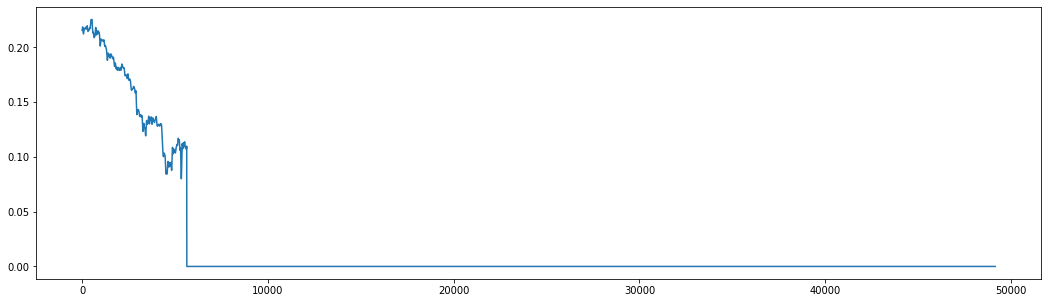

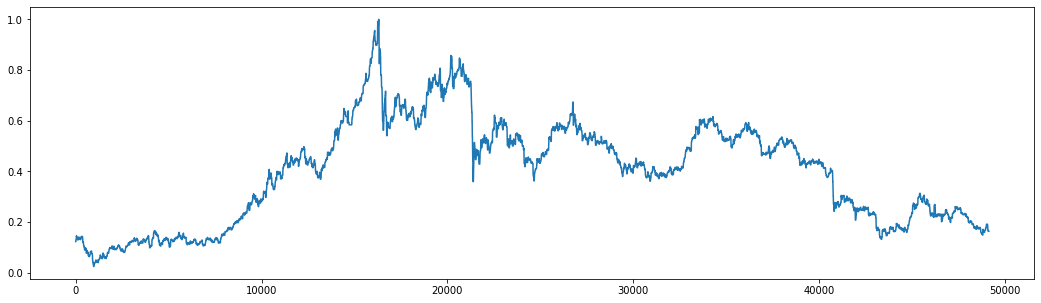

In [19]:
test_plot()